# 星巴克毕业项目

### 简介

这个数据集是一些模拟 Starbucks rewards 移动 app 上用户行为的数据。每隔几天，星巴克会向 app 的用户发送一些推送。这个推送可能仅仅是一条饮品的广告或者是折扣券或 BOGO（买一送一）。一些顾客可能一连几周都收不到任何推送。 

顾客收到的推送可能是不同的，这就是这个数据集的挑战所在。

你的任务是将交易数据、人口统计数据和推送数据结合起来判断哪一类人群会受到某种推送的影响。这个数据集是从星巴克 app 的真实数据简化而来。因为下面的这个模拟器仅产生了一种饮品， 实际上星巴克的饮品有几十种。

每种推送都有有效期。例如，买一送一（BOGO）优惠券推送的有效期可能只有 5 天。你会发现数据集中即使是一些消息型的推送都有有效期，哪怕这些推送仅仅是饮品的广告，例如，如果一条消息型推送的有效期是 7 天，你可以认为是该顾客在这 7 天都可能受到这条推送的影响。

数据集中还包含 app 上支付的交易信息，交易信息包括购买时间和购买支付的金额。交易信息还包括该顾客收到的推送种类和数量以及看了该推送的时间。顾客做出了购买行为也会产生一条记录。 

同样需要记住有可能顾客购买了商品，但没有收到或者没有看推送。

### 示例

举个例子，一个顾客在周一收到了满 10 美元减 2 美元的优惠券推送。这个推送的有效期从收到日算起一共 10 天。如果该顾客在有效日期内的消费累计达到了 10 美元，该顾客就满足了该推送的要求。

然而，这个数据集里有一些地方需要注意。即，这个推送是自动生效的；也就是说，顾客收到推送后，哪怕没有看到，满足了条件，推送的优惠依然能够生效。比如，一个顾客收到了"满10美元减2美元优惠券"的推送，但是该用户在 10 天有效期内从来没有打开看到过它。该顾客在 10 天内累计消费了 15 美元。数据集也会记录他满足了推送的要求，然而，这个顾客并没被受到这个推送的影响，因为他并不知道它的存在。

### 清洗

清洗数据非常重要也非常需要技巧。

你也要考虑到某类人群即使没有收到推送，也会购买的情况。从商业角度出发，如果顾客无论是否收到推送都打算花 10 美元，你并不希望给他发送满 10 美元减 2 美元的优惠券推送。所以你可能需要分析某类人群在没有任何推送的情况下会购买什么。

### 最后一项建议

因为这是一个毕业项目，你可以使用任何你认为合适的方法来分析数据。例如，你可以搭建一个机器学习模型来根据人口统计数据和推送的种类来预测某人会花费多少钱。或者，你也可以搭建一个模型来预测该顾客是否会对推送做出反应。或者，你也可以完全不用搭建机器学习模型。你可以开发一套启发式算法来决定你会给每个顾客发出什么样的消息（比如75% 的35 岁女性用户会对推送 A 做出反应，对推送 B 则只有 40% 会做出反应，那么应该向她们发送推送 A）。


# 数据集

一共有三个数据文件：

* portfolio.json – 包括推送的 id 和每个推送的元数据（持续时间、种类等等）
* profile.json – 每个顾客的人口统计数据
* transcript.json – 交易、收到的推送、查看的推送和完成的推送的记录

以下是文件中每个变量的类型和解释 ：

**portfolio.json**
* id (string) – 推送的id
* offer_type (string) – 推送的种类，例如 BOGO、打折（discount）、信息（informational）
* difficulty (int) – 满足推送的要求所需的最少花费
* reward (int) – 满足推送的要求后给与的优惠
* duration (int) – 推送持续的时间，单位是天
* channels (字符串列表)

**profile.json**
* age (int) – 顾客的年龄 
* became_member_on (int) – 该顾客第一次注册app的时间
* gender (str) – 顾客的性别（注意除了表示男性的 M 和表示女性的 F 之外，还有表示其他的 O）
* id (str) – 顾客id
* income (float) – 顾客的收入

**transcript.json**
* event (str) – 记录的描述（比如交易记录、推送已收到、推送已阅）
* person (str) – 顾客id
* time (int) – 单位是小时，测试开始时计时。该数据从时间点 t=0 开始
* value - (dict of strings) – 推送的id 或者交易的数额


In [2]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# read in the json files
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 概览portfolio

In [3]:
portfolio.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [4]:
portfolio.head()


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


- 只有10个数据 对应不同的推送活动 所以 ifficulty,duration, offer_type,reward可以合并起来 作为一个完整的推送活动名字
- channels 列可以做成onehot编码
    
    
- Only 10 data, so the information of 'offer_type', 'difficulty', 'duration', 'reward'  can all be seen as special content of one offer type, and can be added into one
- The channels column needs to be one-hot encoded.


In [5]:
# 函数: 对portfolio前处理
def portfolio_prep(df):
    # df = portfolio
    # one hot encoded   channels 4 class
    df = df.copy()
    list_channels = ['web', 'email', 'mobile', 'social']

    for ch in list_channels:
        # ch = list_channels[0]
        df[ch] = df.channels.apply(lambda x: 1 if ch in x else 0)

    df = df.drop('channels', axis=1)

    df['offername'] = df.offer_type.astype(str) +'_'+ df.difficulty.astype(str) +'_'+ \
        df.duration.astype(str) +'_'+  df.reward.astype(str)
    
    # df = df.drop( ['offer_type', 'difficulty', 'duration', 'reward']  , axis=1)
   
    return df

In [6]:
portfolio_clean = portfolio_prep( portfolio ) 
portfolio_clean

,reward,difficulty,duration,offer_type,id,web,email,mobile,social,offername
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,bogo_10_7_10
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,bogo_10_5_10
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,informational_0_4_0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,bogo_5_7_5
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,discount_20_10_5
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,discount_7_7_3
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,discount_10_10_2
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,informational_0_3_0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,bogo_5_5_5
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,discount_10_7_2


## 概览profile

In [7]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [8]:
profile.info()
# `became_member_on` data type is int64, need to parse to dates.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


- gender 和 income存在缺失数据   
- became_member_on 应该转化为datetime, 做特征工程的时候 可以减去某个初始值转化为整数
    
    
- There are some missing data for gender and income
- became_member_on should be converted to datetime. When doing feature engineering later, became_member_on column can subtract an initial value and convert to an integer

### age 和 income

In [9]:
profile[['age', 'income']].describe()

,age,income
count,17000.000000,14825.000000
mean,62.531412,65404.991568
std,26.738580,21598.299410
min,18.000000,30000.000000
25%,45.000000,49000.000000
50%,58.000000,64000.000000
75%,73.000000,80000.000000
max,118.000000,120000.000000


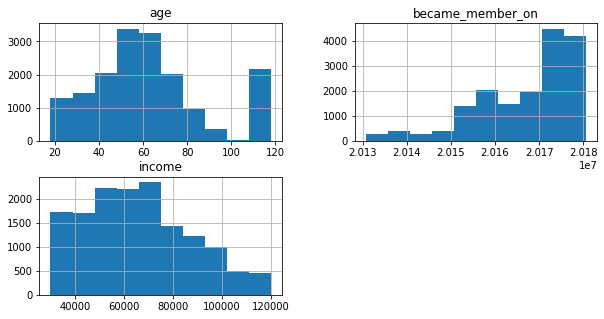

In [10]:
profile[['age', 'income', 'became_member_on']].hist(figsize=(10,5));


- age数据里 有太多118岁的 看上去不正常,总共2175人
- age和income 基本符合正态分布，became_member人数 每年逐渐增多
    
    
- to much 118 years old people (2175) in age columns, seems abnormal
- age and income basically conform to the normal distribution, the number of become_member gradually increases every year

In [11]:
profile[profile.age == 118]['age'].value_counts()  # 2175


118    2175
Name: age, dtype: int64

### 列缺失

In [12]:
profile.isnull().sum()  #  gender 2175, income 2175


gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [13]:
profile[profile.age == 118][ ['gender', 'income'] ]


,gender,income
0,None,NaN
2,None,NaN
4,None,NaN
6,None,NaN
7,None,NaN
...,...,...
16980,None,NaN
16982,None,NaN
16989,None,NaN
16991,None,NaN


- 118岁的用户 在income和gender上都缺失了信息 如果不影响整体特征分布 可以考虑删除。
    
    
- Age at where 118 all missing values in income and gender columns. If it does not affect the overall feature distribution, consider delete these.

### 重复

In [14]:
profile.id.duplicated().sum()  # 无重复

0

### income vs gender

In [15]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

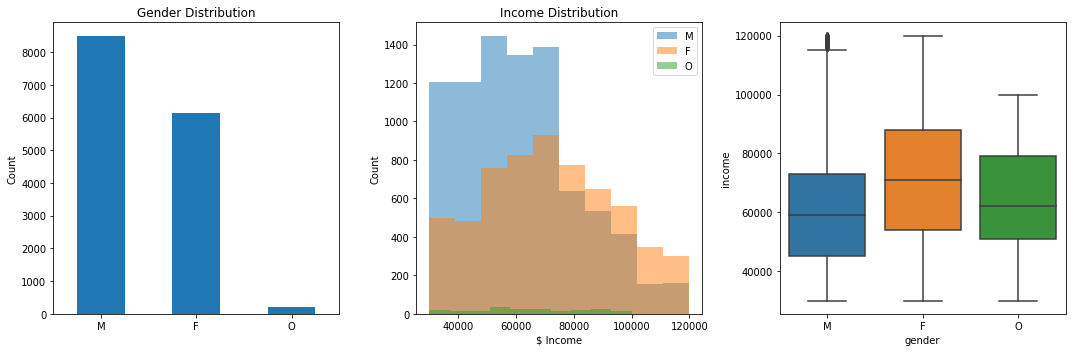

In [16]:
# 分析性别 和 income， 作图 性别count， 不同性别-income hist分布，不同性别-income box图
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,5))

# gender distribution bar
profile.gender.value_counts().plot(kind='bar', ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.set_title('Gender Distribution')
ax1.set_ylabel('Count')

# different gender's income distribution histogram
ax2.hist(profile[profile.gender == 'M']['income'], alpha=0.5, label='M')
ax2.hist(profile[profile.gender == 'F']['income'], alpha=0.5, label='F')
ax2.hist(profile[profile.gender == 'O']['income'], alpha=0.5, label='O')
ax2.set_xlabel('$ Income')
ax2.set_ylabel('Count')
ax2.set_title('Income Distribution')
ax2.legend()

# different gender's income statics box
sns.boxplot('gender', 'income', data=profile, ax=ax3, order=['M', 'F', 'O'])

plt.tight_layout()


- 男性人数较多 女性其次 还有212个没有性别的
- 女性平均收入较高 其次是无性别的 
  
  
- There are more men than women, and 212 people with no gender imfornation.
- Women's average income is higher, followed by genderless

### 转换时间类型

In [17]:

def profile_prep_dates(df):
    # df = profile
    df = df.copy()
    #convert to string
    df['became_member_on'] = pd.to_datetime( df.became_member_on.apply(lambda x: str(x)) )
    return df

profile_clean = profile_prep_dates(profile)

###  行缺失

In [18]:
# How much data is missing in each row of profiile  dataset?
row_null = profile_clean.isnull().sum(axis=1)
row_null.value_counts()


0    14825
2     2175
dtype: int64

- 有2175行缺少了2个特征 占总数的14%
    
    
- There are 2175 rows missing 2 features, 14% of the total

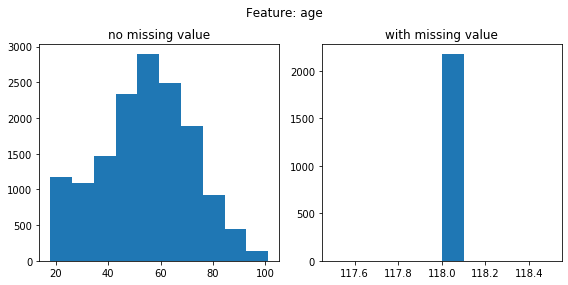

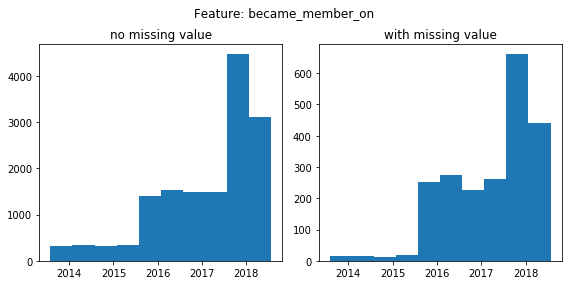

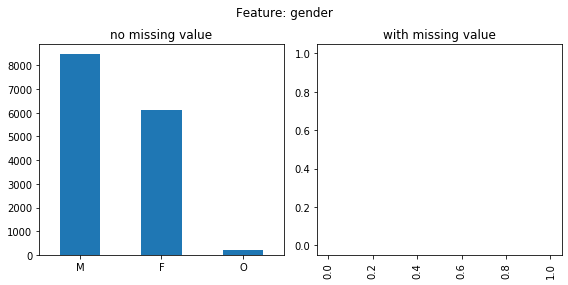

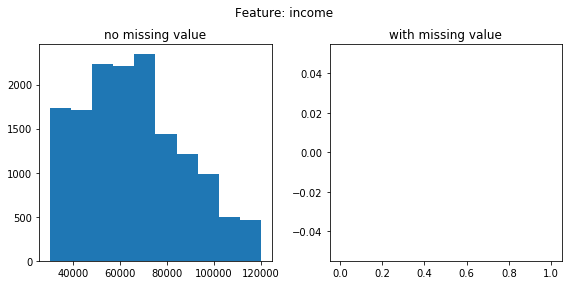

In [19]:
#%%  比较 行缺失 vs 无缺失，在各列下的分布图  有无明显差别 

profile_wonull = profile_clean[row_null ==0]
profile_winull = profile_clean[row_null > 0]


for col in ['age', 'became_member_on','gender', 'income']:
    # col = 'became_member_on'
    f, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
   
    if col == 'gender':
        # col = 'gender'
        profile_wonull[col].value_counts().plot(kind='bar', ax=ax1)
        ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(),rotation=0)
        try :
            profile_winull[col].value_counts().plot(kind='bar', ax=ax2)
            
        except:
            pass
    else:
        profile_wonull[col].hist(ax=ax1)
        profile_winull[col].hist(ax=ax2)
    
    ax1.grid(False)
    ax2.grid(False)
    ax1.set_title('no missing value' )
    ax2.set_title('with missing value')
    f.suptitle('Feature: ' + col)
    f.tight_layout()
    f.subplots_adjust(top=0.85)
    

- 对于缺失数据的行，在　became_member_on这个特征上和无缺失行　没有明显的分布规律差别,可以删除
    
    
- For rows with missing data, there is no obvious difference in the distribution pattern of "became_member_on" with no missing rows. These rows can be deleted.

In [20]:
profile_clean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               17000 non-null  int64         
 2   id                17000 non-null  object        
 3   became_member_on  17000 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 664.2+ KB


## 概览 Transcript

In [21]:
transcript.head()


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [22]:
transcript.sample(20)

,person,event,value,time
62305,206ce5f33eb14623888263d2b945d089,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},168
224725,3b34370727654cfca5322bca2aba9ffd,transaction,{'amount': 17.92},516
269254,923afabe892840a4a909b00a3114a290,transaction,{'amount': 0.68},594
51739,53e8bb88915e405db140e25ae136bf1d,transaction,{'amount': 15.49},156
149137,b7e216b6472b46648272c29a52a86702,offer viewed,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},402
22831,e008262ad24e46af98a928342e303c3e,offer viewed,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},24
29726,4300a41fca2143a38b46941de668f6d6,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,48
76561,899ed0c4994f47c4b3dd71eb929870bc,offer viewed,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},186
213068,bba1aa88ea0240b5a66390c0c910041d,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},504
168504,471938c318674a30afea015be6396cbd,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,414


In [23]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


### 缺失

In [25]:
transcript.isnull().sum()  # no null


person    0
event     0
value     0
time      0
dtype: int64

###  event 和 value

In [26]:
transcript.event.value_counts()


transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [28]:
transcript.value.sample(20)


45857                                       {'amount': 5.5}
79152      {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
139404                                     {'amount': 2.35}
169603     {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
232562                                    {'amount': 26.27}
230088                                     {'amount': 6.88}
283297     {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
206571     {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
231843                                     {'amount': 3.17}
242742                                     {'amount': 4.77}
140548    {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
83927      {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
35596                                     {'amount': 34.34}
230081                                      {'amount': 7.2}
47859                                      {'amount': 1.35}
59310      {'offer id': '3f207df678b143eea3cee63160fa8bed'}
121756     {'offer id': '0b1e1539f2cc45b

- value 列有两种情况 'offer id' 或者'offer_id' 字典，值为offerid，'amount'字典，值为交易量，因此这一列需要拆成2列，分别用'offer_id'和'amount'作为列名，值为对应的字典值，注意需要把'offer id'变为'offer_id'

- event 列有4种活动，其中 offer received, offer viewed and offer completed 都是和 offer 有关 对应了value列的'offer id'，transaction 对应了value列的'amount'

    
- value column has two types, one is dict of 'offer id' and 'offer_id'!!!!!!!!!!! the other is dict of 'amount'
- event column has two types, one is offer received, viewed and completed, the other is transaction
- event transaction corresponds to value amount, and other event offer actions corresponds to value offer_id.
- dict of 'offer id'and 'offer_id' can get a new column named 'offer id' in the row of offer event
- dict of 'amount' can get a new column named 'amount' in the row of transaction

In [29]:
transcript.person.unique().shape


(17000,)

### 增加两列 offer_id  and  amount 

In [36]:

def encode_offer_id(x):
    try :
        return x['offer id']
    except:
        return x['offer_id']

def transcript_prep(df):
    # df = transcript
    trans_df = df.copy()
    trans_df['offer_id'] = trans_df[~trans_df.event.isin(['transaction'])].value.apply(encode_offer_id)   # why can't lambda?
    trans_df['amount'] =  trans_df[trans_df.event.isin(['transaction'])].value.apply(lambda x: x['amount'])
    trans_df = trans_df.drop( 'value' , axis=1 )
    return trans_df

In [38]:
transcript_try = transcript_prep(transcript)
transcript_try.sample(10)

,person,event,time,offer_id,amount
177141,46932b6613b7405a975d4b4ef1ef9669,offer viewed,426,f19421c1d4aa40978ebb69ca19b0e20d,NaN
56965,50a2b91918ba45b6bcd2556f70c75aa0,offer received,168,fafdcd668e3743c1bb461111dcafc2a4,NaN
11916,fada060561c24d4a984cc6eba6e2a63a,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
207500,8cc382605ece4420a536e2123e05444b,offer received,504,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
129940,18eb8fa6fd8a4416a62569f5e16709e5,transaction,342,NaN,16.57
249046,404bff404fbc4024bfd1da1134594b3f,offer received,576,fafdcd668e3743c1bb461111dcafc2a4,NaN
11058,fbded35ba79e4b898f5fc7faee6ff44f,offer received,0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
135169,da7aced8db154427a94a9008200267e4,transaction,354,NaN,0.67
131032,6fae0fe809b34a45bd87deb5e317adec,transaction,348,NaN,24.47
87713,beb7f9bb1096496fa4a369be8d0c6137,offer viewed,222,fafdcd668e3743c1bb461111dcafc2a4,NaN


## 三个合并  profile， portfolio， transcript  


In [31]:
print( portfolio_clean.columns) 
print( profile_clean.columns )
print( transcript.columns )


Index(['reward', 'difficulty', 'duration', 'offer_type', 'id', 'web', 'email',
       'mobile', 'social', 'offername'],
      dtype='object')
Index(['gender', 'age', 'id', 'became_member_on', 'income'], dtype='object')
Index(['person', 'event', 'value', 'time'], dtype='object')


In [39]:
def merge_transcript_profile_portfolio(transcript_df, profile_df, portfolio_df):
    # transcript_df= transcript ; profile_df = profile; portfolio_df = portfolio
    portfolio_clean = portfolio_prep( portfolio_df ) 
    profile_clean = profile_prep_dates(profile_df)
    transcript_clean = transcript_prep(transcript_df)
    
    dfmerge_tr_pr = pd.merge(transcript_clean, profile_clean, left_on=['person'], right_on = ['id'], how ='left')
    dfmerge_tr_pr = dfmerge_tr_pr.drop(['id'], axis=1)
    
    dfmerge_trpr_po =  pd.merge(dfmerge_tr_pr, portfolio_clean, left_on = 'offer_id', right_on ='id', how='left')
    dfmerge_trpr_po = dfmerge_trpr_po.drop(['id'], axis=1)
    return dfmerge_trpr_po


In [73]:
dfmerge_trprpo = merge_transcript_profile_portfolio(transcript, profile, portfolio)

In [74]:
dfmerge_trprpo.head()

,person,event,time,offer_id,amount,gender,age,became_member_on,income,reward,difficulty,duration,offer_type,web,email,mobile,social,offername
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,bogo_5_7_5
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,None,118,2017-08-04,NaN,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0,discount_20_10_5
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,M,68,2018-04-26,70000.0,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0,discount_10_7_2
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,None,118,2017-09-25,NaN,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0,discount_10_10_2
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,None,118,2017-10-02,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,bogo_10_5_10


### 缺失

In [75]:
dfmerge_trprpo.isnull().sum()

person                   0
event                    0
time                     0
offer_id            138953
amount              167581
gender               33772
age                      0
became_member_on         0
income               33772
reward              138953
difficulty          138953
duration            138953
offer_type          138953
web                 138953
email               138953
mobile              138953
social              138953
offername           138953
dtype: int64

## 数据探索

### amount 平均，总数 ， 次数

count    16578.000000
mean        13.680266
std         16.056763
min          0.050000
25%          3.181392
50%         11.996607
75%         20.469643
max        451.470000
Name: amount, dtype: float64

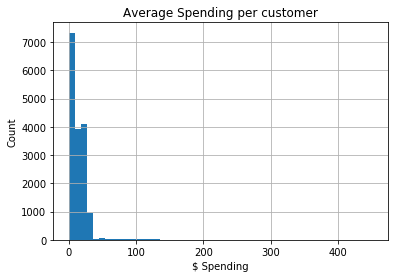

In [76]:
# 所有用户用户的 交易情况 amount 平均值分布
dfmerge_trprpo.groupby('person')['amount'].mean().hist(bins=50)
plt.xlabel('$ Spending')
plt.ylabel('Count')
plt.title('Average Spending per customer')
dfmerge_trprpo.groupby('person')['amount'].mean().describe()

count    17000.000000
mean       104.438351
std        125.922619
min          0.000000
25%         21.820000
50%         69.405000
75%        148.782500
max       1608.690000
Name: amount, dtype: float64

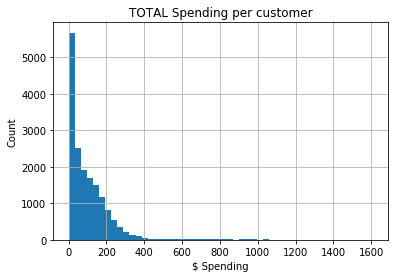

In [77]:
# 所有用户的 交易情况 amount 总和分布

dfmerge_trprpo.groupby('person')['amount'].sum().hist(bins=50)
plt.xlabel('$ Spending')
plt.ylabel('Count')
plt.title('TOTAL Spending per customer')
dfmerge_trprpo.groupby('person')['amount'].sum().describe()



count    17000.000000
mean         8.173706
std          5.116250
min          0.000000
25%          4.000000
50%          7.000000
75%         11.000000
max         36.000000
Name: amount, dtype: float64

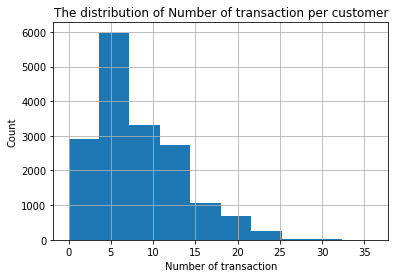

In [78]:
# 所有用户的 交易情况 amount  count 分布

dfmerge_trprpo.groupby('person')['amount'].count().hist()
plt.xlabel('Number of transaction')
plt.ylabel('Count')
plt.title('The distribution of Number of transaction per customer')
dfmerge_trprpo.groupby(['person'])['amount'].count().describe()


- 用户单次交易的平均值是16元，大部分都在20元以下
- 用户交易量的平均值是125元，大部分都在150元以下
- 用户交易次数的平均值是8次，大部分都在11次以下
    

- The average value of a user's single transaction is 16 yuan, most of which are below 20 yuan
- The average value of a user's total transaction is 125 yuan, most of which are below 150 yuan
- The average value of a user's transactions count is 8, and most of them are below 11


### amount vs gender

In [79]:
# assign missing value in gender with 'U' value
dfmerge_temp = dfmerge_trprpo.copy()
dfmerge_temp.loc[dfmerge_temp.gender.isnull(), 'gender'] ='U'

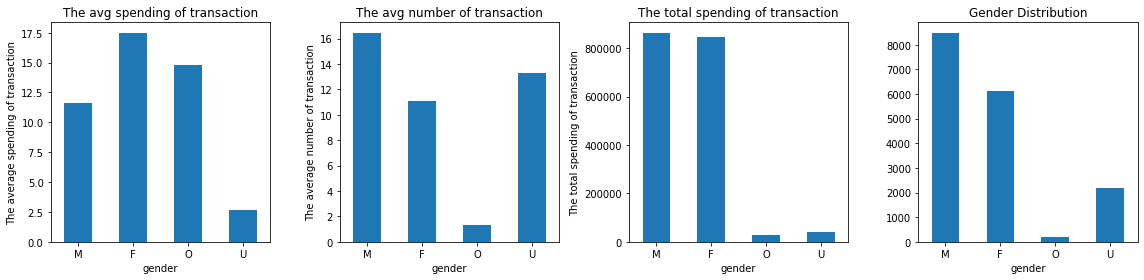

In [82]:
# 分析  不同性别-用户的 交易情况 amount 平均值 分布， 以及 不同性别-用户的  amount 计数，  不同性别-用户的  income box图

""" The number of transaction by GENDER """

#plot avg spending
f, (ax1, ax2, ax3 , ax4) = plt.subplots(1,4, figsize=(16,4))
dfmerge_temp.groupby('gender')['amount'].mean()[['M', 'F', 'O', 'U']].plot(kind='bar', ax=ax1);
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.set_ylabel("The average spending of transaction")
ax1.set_title('The avg spending of transaction')

# plot avg number of transaction

dfmerge_temp.groupby(['gender', 'amount'])['amount'].count().mean(level=0)[['M', 'F', 'O', 'U']].plot(kind='bar', ax=ax2);
ax2.set_xticklabels(ax1.get_xticklabels(), rotation=0);
ax2.set_ylabel("The average number of transaction");
ax2.set_title("The avg number of transaction");

# boxplot income distribution
dfmerge_temp.groupby('gender')['amount'].sum().plot(kind='bar', ax=ax3);
ax3.set_xticklabels(ax1.get_xticklabels(), rotation=0);
ax3.set_ylabel("The total spending of transaction");
ax3.set_title("The total spending of transaction");

#plot gender distribution
profile.fillna('U').gender.value_counts()[['M', 'F', 'O', 'U']].plot(kind='bar', ax=ax4)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=0)
plt.title('Gender Distribution');
ax4.set_xlabel('gender')

plt.tight_layout()

- 女性的平均交易量最多, 其次是其他性别和男性
- 男性的交易次数最多, 其次是其他性别和女性
- 男性女性的总交易量比较接近,可能是因为男性虽然单次交易量少,但是人数多.其他性别和unknown的总交易量都很少
    
    
- Women have the most average spending, followed by other genders and men
- Men have the most average transaction count, followed by other genders and women
- The total spending of males and females is relatively close, which may be due to the fact that although the males' single transaction spending is small, the number of males is large.The total spending of other genders and unknown is very small

### offer event count

Text(0.5, 1.0, 'Portfolio Distribution by Event')

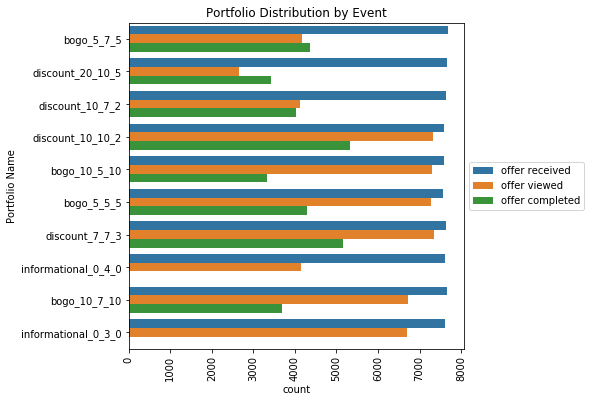

In [83]:
# 分析 查看不同offer 的 receive view 和 complete 数量，水平图

"""
Portfolio Distribution by event
"""
df_temp = dfmerge_trprpo[~dfmerge_trprpo.event.isin(['transaction'])]
plt.figure(figsize=(6,6))
sns.countplot(y='offername', hue='event', data= df_temp);
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=90)
plt.ylabel("Portfolio Name")
plt.title("Portfolio Distribution by Event")

# 发现 complete 竟然比 view还多 说明有的人 complete 和推荐无关 属于无效记录


-  对于bogo_5_7_5和discount_20_10_5这两种推送，complete 竟然比 view还多 说明有的人 complete 和推送无关, 属于无效记录
    
    
- For push offers bogo_5_7_5 and discount_20_10_5, complete count is even more than view count, indicating that some complete event has nothing to do with push offers,these are invalid records


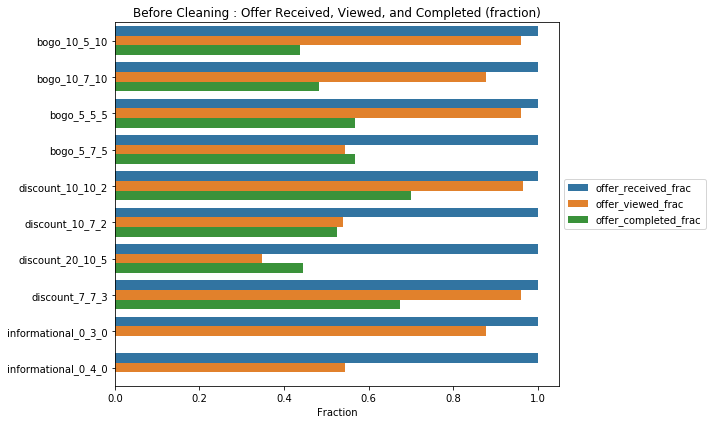

In [87]:
# 分析 查看不同offer的比例  receive view 和 complete 数量 / receive数量，水平图

event_count = dfmerge_trprpo[~dfmerge_trprpo.event.isin(['transaction'])].groupby(['offername', 'event']).offer_id.count().unstack()
event_count['offer_received_frac'] = event_count['offer received']/ event_count['offer received']
event_count['offer_viewed_frac'] = event_count['offer viewed']/ event_count['offer received']
event_count['offer_completed_frac'] =  event_count['offer completed']/ event_count['offer received']

event_count_frac = event_count[['offer_received_frac','offer_viewed_frac', 'offer_completed_frac']]

event_count_stack = event_count_frac.stack().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x=0,y='offername', hue='event', data=event_count_stack)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplots_adjust(top=0.8)
plt.title("Before Cleaning : Offer Received, Viewed, and Completed (fraction)")
plt.ylabel('')
plt.xlabel('Fraction')

plt.tight_layout()

### find invalid transaction 

In [88]:
# 函数 find_invalid_index 找到无效推荐所在行


def find_invalid_index( df_merged ):
    """
    INPUT : transcript, profile, portfolio dataframe
    RETURN : a list of invalid index in transcript dataframe
    """
    # transcript_df= transcript ; profile_df = profile; portfolio_df = portfolio

    # df_merged = dfmerge_trprpo
    df_merg = df_merged.copy()
    list_invalid = []

    #iterate over profile_id (person)
    list_person = df_merg.person.unique()
    for person_id in tqdm( list_person ) :
        # person_id= list_person[0]
        # take a subest_df for profile_id person
        df_sub_person = df_merg[df_merg.person == person_id]
        
        # take a subset of 'offer completed'
        df_subp_comp = df_sub_person[df_sub_person.event == 'offer completed']

        # iterate over the completed offer_id
        for comofferid in df_subp_comp.offer_id.unique():
            # comofferid = df_subp_comp.offer_id.unique()[0]
            
            # take a subset df of completed offer
            row_com = df_subp_comp[df_subp_comp.offer_id == comofferid]
            
            # estimate the offer received time in hours using the offer duration (in days)
            start_time = row_com.time.values - (row_com.duration.values *24)
            # the offer completed time
            comp_time = row_com.time.values
            # take the subset within start_time and comp_time            
            df_sub_durng = df_sub_person[(df_sub_person.time >= start_time[0]) & (df_sub_person.time <= comp_time[0])]
            df_sub_view =  df_sub_durng[ (df_sub_durng.event == 'offer viewed')  & (df_sub_durng.offer_id == comofferid) ]
            
            # take only event of offer viewed for the given offer_id
            if len(df_sub_view) ==0  :
                list_invalid.extend( row_com.index  )
                
    return list_invalid

In [89]:
list_invalid = find_invalid_index( dfmerge_trprpo )

100%|████████████████████████████████████| 17000/17000 [06:55<00:00, 40.90it/s]


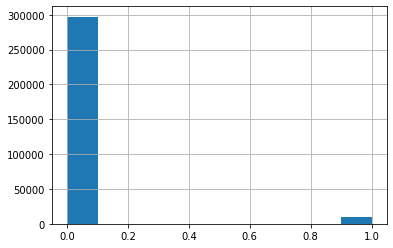

In [90]:
#%% 给无效行 做标记

dfmerge_trprpo.loc[ :,'invalid'] = 0
dfmerge_trprpo.loc[ list_invalid,'invalid'] =1

dfmerge_trprpo.invalid.hist()


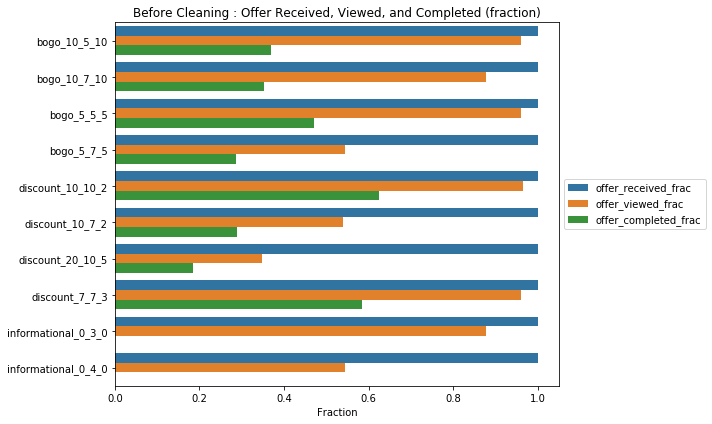

In [91]:
#%% 去掉无效行以后 重新统计  不同offer- receive view 和 complete 比例，水平图

df_trprpo_valid = dfmerge_trprpo[ dfmerge_trprpo.invalid == 0 ]

event_count = df_trprpo_valid[~df_trprpo_valid.event.isin(['transaction'])].groupby(['offername', 'event']).offer_id.count().unstack()
event_count['offer_received_frac'] = event_count['offer received']/ event_count['offer received']
event_count['offer_viewed_frac'] = event_count['offer viewed']/ event_count['offer received']
event_count['offer_completed_frac'] =  event_count['offer completed']/ event_count['offer received']

event_count_frac = event_count[['offer_received_frac','offer_viewed_frac', 'offer_completed_frac']]

event_count_stack = event_count_frac.stack().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x=0,y='offername', hue='event', data=event_count_stack)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplots_adjust(top=0.8)
plt.title("Before Cleaning : Offer Received, Viewed, and Completed (fraction)")
plt.ylabel('')
plt.xlabel('Fraction')

plt.tight_layout()



- 对于所有推送offer 发现 complete 比 view 少，说明只剩下了有效记录
    
    
- For all push offers, it is found that complete is less than view, indicating that only valid records are left

# 函数集合

In [92]:
#%% 函数 前面定义的
def portfolio_prep(df):
    # df = portfolio
    # one hot encoded   channels 4 class
    df = df.copy()
    list_channels = ['web', 'email', 'mobile', 'social']

    for ch in list_channels:
        # ch = list_channels[0]
        df[ch] = df.channels.apply(lambda x: 1 if ch in x else 0)

    df = df.drop('channels', axis=1)

    df['offername'] = df.offer_type.astype(str) +'_'+ df.difficulty.astype(str) +'_'+ \
        df.duration.astype(str) +'_'+  df.reward.astype(str)
    
    # df = df.drop( ['offer_type', 'difficulty', 'duration', 'reward']  , axis=1)
   
    return df


def profile_prep_dates(df):
    # df = profile
    df = df.copy()
    #convert to string
    df['became_member_on'] = pd.to_datetime( df.became_member_on.apply(lambda x: str(x)) )
    return df

def load_file(filepath):
    """Load file csv"""
    df_clean = pd.read_csv(filepath)
    df_clean = df_clean.set_index(df_clean.columns[0])
    df_clean = profile_prep_dates(df_clean)
    return df_clean


def encode_offer_id(x):
    try :
        return x['offer id']
    except:
        return x['offer_id']

def transcript_prep(df):
    # df = transcript
    trans_df = df.copy()
    trans_df['offer_id'] = trans_df[~trans_df.event.isin(['transaction'])].value.apply(encode_offer_id)   # why can't lambda?
    trans_df['amount'] =  trans_df[trans_df.event.isin(['transaction'])].value.apply(lambda x: x['amount'])
    trans_df = trans_df.drop( 'value' , axis=1 )
    return trans_df

def merge_transcript_profile_portfolio(transcript_df, profile_df, portfolio_df):
    # transcript_df= transcript ; profile_df = profile; portfolio_df = portfolio
    portfolio_clean = portfolio_prep( portfolio_df ) 
    profile_clean = profile_prep_dates(profile_df)
    transcript_clean = transcript_prep(transcript_df)
    
    dfmerge_tr_pr = pd.merge(transcript_clean, profile_clean, left_on=['person'], right_on = ['id'], how ='left')
    dfmerge_tr_pr = dfmerge_tr_pr.drop(['id'], axis=1)
    
    dfmerge_trpr_po =  pd.merge(dfmerge_tr_pr, portfolio_clean, left_on = 'offer_id', right_on ='id', how='left')
    dfmerge_trpr_po = dfmerge_trpr_po.drop(['id'], axis=1)
    return dfmerge_trpr_po



def find_invalid_index( df_merged ):
    """
    INPUT : transcript, profile, portfolio dataframe
    RETURN : a list of invalid index in transcript dataframe
    """
    # transcript_df= transcript ; profile_df = profile; portfolio_df = portfolio

    # df_merged = dfmerge_trprpo
    df_merg = df_merged.copy()
    list_invalid = []

    #iterate over profile_id (person)
    list_person = df_merg.person.unique()
    for person_id in tqdm( list_person ) :
        # person_id= list_person[0]
        # take a subest_df for profile_id person
        df_sub_person = df_merg[df_merg.person == person_id]
        
        # take a subset of 'offer completed'
        df_subp_comp = df_sub_person[df_sub_person.event == 'offer completed']

        # iterate over the completed offer_id
        for comofferid in df_subp_comp.offer_id.unique():
            # comofferid = df_subp_comp.offer_id.unique()[0]
            
            # take a subset df of completed offer
            row_com = df_subp_comp[df_subp_comp.offer_id == comofferid]
            
            # estimate the offer received time in hours using the offer duration (in days)
            start_time = row_com.time.values - (row_com.duration.values *24)
            # the offer completed time
            comp_time = row_com.time.values
            # take the subset within start_time and comp_time            
            df_sub_durng = df_sub_person[(df_sub_person.time >= start_time[0]) & (df_sub_person.time <= comp_time[0])]
            df_sub_view =  df_sub_durng[ (df_sub_durng.event == 'offer viewed')  & (df_sub_durng.offer_id == comofferid) ]
            
            # take only event of offer viewed for the given offer_id
            if len(df_sub_view) ==0  :
                list_invalid.extend( row_com.index  )
                
    return list_invalid

In [93]:
#%% 函数  根据amount提取消费信息， fillna ,   特征提取

def addfeat_spending(df, profile_id):
    """
    INPUT :
        df : DataFrame, clean merge transcript df
        profile_id : profile id
    RETURN :
        spending_series : a Series of spending for a given profile_id (avg, transaction_count, and sum_spending)

    """
    # df = df_trprpo_valid.copy() ; profile_id = df_trprpo_valid.person[0]
    avg_spending = df.amount.mean()
    transaction_count = df.amount.count()
    sum_spending = df.amount.sum()

    spending_series = pd.Series([avg_spending, transaction_count, sum_spending], index=["avg_spending", "transaction_count", 'sum_spending'], name=profile_id)
    return spending_series



def addfeat_rate(df, profile_id):
    """
    INPUT :
        df : DataFrame, clean merge transcript df
        profile_id : profile id
    RETURN :
        rate_series : a Series of complete/ recieve ,  complete/ review

    """
    # df = df_trprpo_valid.copy() ; profile_id = df_trprpo_valid.person[0]

    offer_received_count = len(df[df.event == 'offer received' ])
    offer_viewed_count = len(df[df.event == 'offer viewed' ])
    offer_completed_count = len(df[df.event == 'offer completed' ])

    rate_comp_rec= offer_completed_count/( offer_received_count + 0.001) 
    rate_comp_view= offer_completed_count/( offer_viewed_count + 0.001) 

    rate_series = pd.Series([rate_comp_rec, rate_comp_view], index=["rate_comp_rec", "rate_comp_view"], name=profile_id)
    return rate_series


def addfeat_offercount(df, profile_id):
    """
    INPUT :
        df : DataFrame, clean merge transcript df
        profile_id : profile id
    RETURN :
        offercount_series : a Series of different offer type count 

    """
    # df = df_trprpo_valid.copy() ; profile_id = df_trprpo_valid.person[0]
    ofbogo_count = len(df[df.offer_type == 'bogo' ])
    ofdisc_count = len(df[df.offer_type == 'discount' ])
    ofinfor_count = len(df[df.offer_type == 'informational' ])

    offercount_series = pd.Series([ofbogo_count, ofdisc_count, ofinfor_count], index=['ofbogo_count', 'ofdisc_count','ofinfor_count'], name=profile_id)
    return offercount_series


def addfeat_invalid(df_all, profile_id):
    """
    INPUT :
        df : DataFrame, clean merge transcript df
        profile_id : profile id
    RETURN :
        offercount_series : a Series of different offer type count 

    """
    # df = subset_dfall.copy() ; profile_id = df_trprpo_valid.person[0]
    invalid_count = len(df_all[df_all.invalid == 1 ])
    invalid_series = pd.Series([invalid_count], index=['invalid_count'], name=profile_id)
    return invalid_series


def feature_fillna(profile_updated_df, cols_to_fillna):
    """
    This function is to fill missing value with zero (0) for selected feature
    INPUT: profile_updated_df with missing values
    RETURN : profile_updated_df with no missing values
    """
    # profile_updated_df = profile_updated
    profile_updated_df = profile_updated_df.copy()
    col_null_frac = profile_updated_df.isnull().sum() / profile_updated_df.shape[0]
    cols_to_drop = col_null_frac[col_null_frac ==1].index.tolist()
    profile_updated_df[cols_to_fillna] = profile_updated_df[cols_to_fillna].fillna(0)
    profile_updated_df = profile_updated_df.drop(cols_to_drop, axis=1)
    return profile_updated_df



# 特征提取 在merge_df里，筛选每个person的df 生成交易信息ser，再根据id和 profile_df合并到一起
# 还可以生成更多的ser 比如无效交易的数量，完成/接收比 完成/查看比例等等
def feature_extraction( df, df_all, profile_df):
    """
    INPUT :
        transcript_clean_df : a clean transcript df
        transcript_all_df : transcript all df as return by transcript_preprocessing function
        portfolio_df : portfolio df
    RETURN :
        profile_updated : profile updated df with 92 features

    This function will check first whether the saved "profile_updated.csv" is available
    If not available, the next function code block will be execute, then save it.
    """
    # df = df_trprpo_valid ; df_all = dfmerge_trprpo; profile_df = profile
    try:
        profile_updated = load_file('data/profile_updated.csv')
        print("The profile_updated.csv file is available at local folder.")
    except:
        df_trprpo_valid = df.copy()
        df_trprpo_all = df_all.copy()
        
        list_addfeat = ["avg_spending", "transaction_count", 'sum_spending', \
                        "rate_comp_rec", "rate_comp_view",\
                        'ofbogo_count', 'ofdisc_count','ofinfor_count',\
                        'invalid_count'   ]
        allfeat_df = pd.DataFrame(index=list_addfeat)

        ar_personid = df_trprpo_valid.person.unique()
        
        for profile_id in tqdm( ar_personid ):
            # profile_id = ar_personid[0]
            subset_df = df_trprpo_valid[df_trprpo_valid.person == profile_id]
            spending_series = addfeat_spending( subset_df, profile_id )
            rate_series = addfeat_rate( subset_df, profile_id ) 
            ofcount_series  = addfeat_offercount( subset_df, profile_id ) 
            
            allfeat_df.loc[ spending_series.index , profile_id] = spending_series.values
            allfeat_df.loc[ rate_series.index , profile_id]=  rate_series.values
            allfeat_df.loc[ ofcount_series.index , profile_id]=  ofcount_series.values
            
            subset_dfall = df_trprpo_all[df_trprpo_all.person == profile_id]
            invalid_series  = addfeat_invalid( subset_dfall, profile_id ) 
            allfeat_df.loc[ invalid_series.index , profile_id] = invalid_series.values     
            
        #parse dates became_member_on in profile_df
        profile_date = profile_prep_dates(profile_df)

        #df concatenation
        profile_updated = pd.concat([profile_date.set_index('id'),allfeat_df.T ], axis=1, sort=False)
        profile_updated = feature_fillna(profile_updated, list_addfeat)

        #saving
        profile_updated.to_csv('data/profile_updated.csv')

    return profile_updated


def pklsave(model, filename):
    """
    This function is to save the sklearn object
    INPUT :
        model : sklearn object
        filename : filepath to saved
    RETURN : none
    """
    pickle.dump(model, open(filename,'wb'))


def pklload(filename):
    """
    This function is to load the saved sklearn object
    INPUT : filename : filepath
    RETURN : loaded sklearn object
    """
    return pickle.load(open(filename, 'rb'))


# 特征工程

## 清洗，合并，处理数据和增加特征

In [94]:

# 合并
dfmerge_trprpo = merge_transcript_profile_portfolio(transcript, profile, portfolio)
# 找到并排除 invalid
list_invalid = find_invalid_index( dfmerge_trprpo )
dfmerge_trprpo.loc[ :,'invalid'] = 0
dfmerge_trprpo.loc[ list_invalid,'invalid'] =1
df_trprpo_valid = dfmerge_trprpo[ dfmerge_trprpo.invalid == 0 ]
# 利用 valid 数据做特征提取
profile_updated = feature_extraction( df_trprpo_valid, dfmerge_trprpo,  profile  )    


100%|████████████████████████████████████| 17000/17000 [06:50<00:00, 41.37it/s]


The profile_updated.csv file is available at local folder.


## 缺失

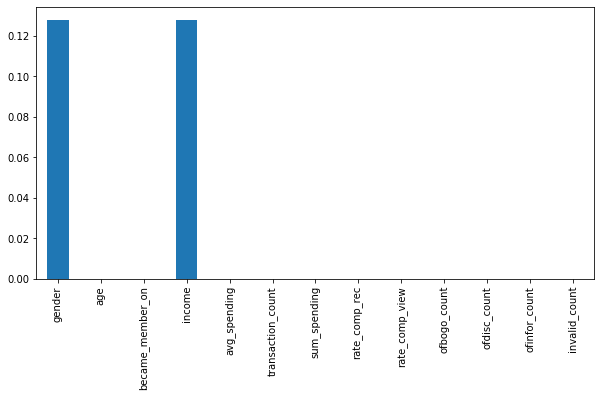

In [95]:
#%% 看看每列缺失多少   Assess missing data in columns

col_null = profile_updated.isnull().sum()

col_null_frac = col_null / profile_updated.shape[0]
plt.figure(figsize= (10,5))
col_null_frac.plot(kind='bar')

In [96]:
#%%  找到并删除 超过0.3比例的空缺列

# cols to drop that have more than 30% missing values
cols_to_drop = col_null_frac[col_null_frac > 0.3].index.tolist()
cols_to_drop

# drop columns in cols_to_drop
profile_up_nomiss = profile_updated.drop(cols_to_drop, axis=1)

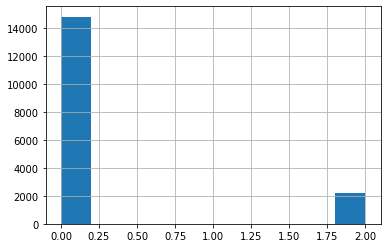

In [97]:
#%% 看看各行 缺失 多少

row_null = profile_up_nomiss.isnull().sum(axis=1)
row_null.hist()

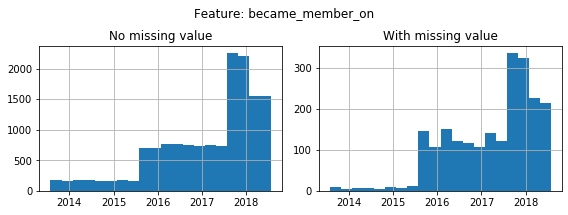

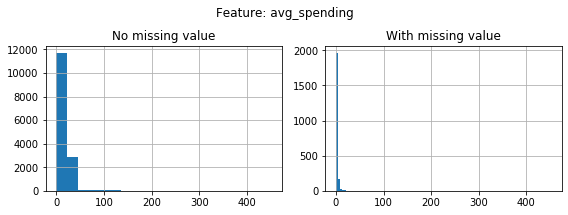

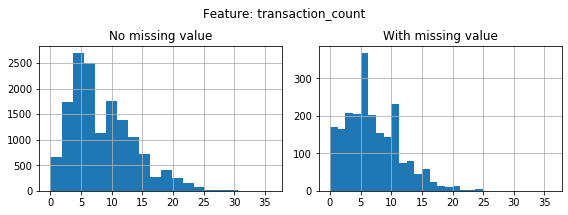

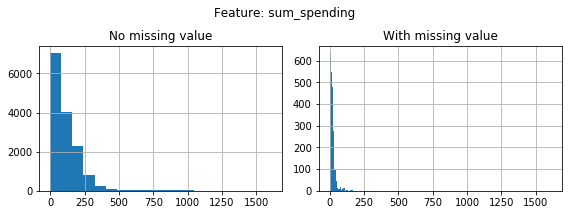

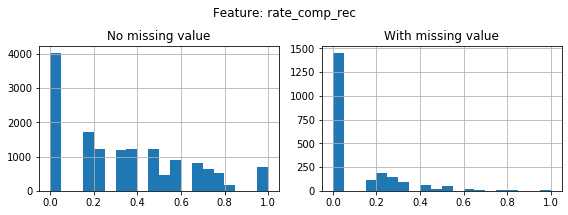

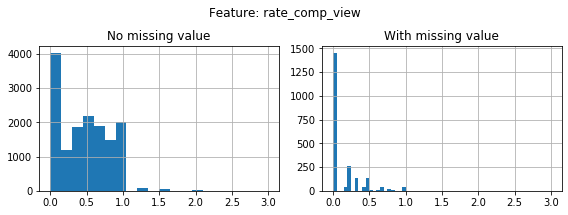

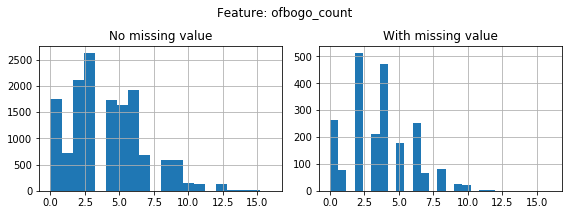

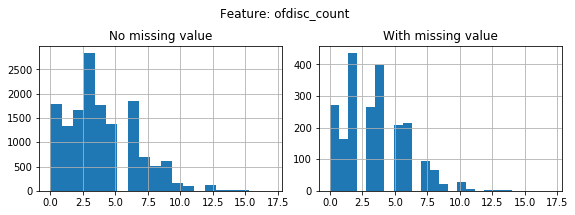

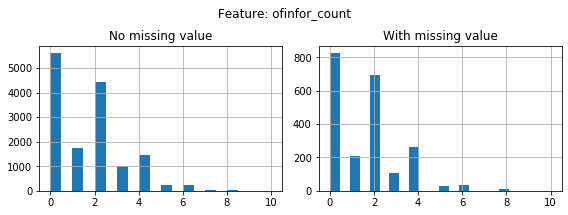

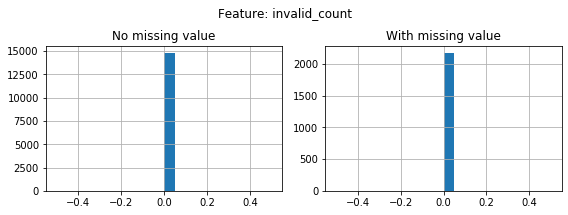

In [98]:
# 观察有缺失行和没缺失行 关心的预测列 hist分布
  
def dist_compare_cont(attribute, data):
    """
    input : 
        attribute: feature / attribute
        data : dataframe
    return : None, only plot the histogram
    """
    # data = profile_updated_  ;  attribute = 'avg_spending'
    row_null = data.isnull().sum(axis=1)
    f, (ax1,ax2) = plt.subplots(1,2, sharex=True, figsize=(8,3))
    ax1 = data[row_null==0][attribute].hist(ax=ax1, bins=20)
    ax2 = data[row_null > 0][attribute].hist( ax=ax2, bins=20)
    ax1.set_title('No missing value')
    ax2.set_title('With missing value')
    f.suptitle('Feature: ' + attribute)
    f.tight_layout()
    f.subplots_adjust(top=0.8)


cols_to_compare = ['became_member_on', 'avg_spending', 'transaction_count', 'sum_spending', 
                   'rate_comp_rec', 'rate_comp_view','ofbogo_count', 'ofdisc_count', 
                   'ofinfor_count', 'invalid_count']

for col in cols_to_compare:
    dist_compare_cont(col, profile_up_nomiss)

- 发现 No missing 和 With missing 两者相比 没有明显差别 可以考虑删除
    
    
- It is found that data with missing and without missing have no obvious difference, the missing rows can be deleted

In [99]:
#%% 删除这部分缺失的行 
profile_up_nomiss = profile_up_nomiss.drop( profile_up_nomiss[row_null > 0].index  , axis=0)

## 特征工程， became_member_on


In [100]:
# became_member_on 转换为2个  member_days_since 和 member_year
profile_up_nomiss.loc[:,'member_days_since'] = (datetime.datetime(2018,12,31) - \
                     profile_up_nomiss.became_member_on).dt.days 
                     
profile_up_nomiss.loc[:,'member_year'] = profile_up_nomiss.became_member_on.dt.year.astype(str)
profile_up_nomiss = profile_up_nomiss.drop('became_member_on', axis=1)


In [101]:
#%%  确认类型 年月日是否为 str, 是否还有其他str
profile_up_nomiss.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14825 entries, 0610b486422d4921ae7d2bf64640c50b to e4052622e5ba45a8b96b59aba68cf068
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             14825 non-null  object 
 1   age                14825 non-null  int64  
 2   income             14825 non-null  float64
 3   avg_spending       14825 non-null  float64
 4   transaction_count  14825 non-null  float64
 5   sum_spending       14825 non-null  float64
 6   rate_comp_rec      14825 non-null  float64
 7   rate_comp_view     14825 non-null  float64
 8   ofbogo_count       14825 non-null  float64
 9   ofdisc_count       14825 non-null  float64
 10  ofinfor_count      14825 non-null  float64
 11  invalid_count      14825 non-null  float64
 12  member_days_since  14825 non-null  int64  
 13  member_year        14825 non-null  object 
dtypes: float64(10), int64(2), object(2)
memory usage: 1.7+ MB


## one hot: gender, member_year

In [102]:
#%% 再次 one hot 编码，主要是 gender 和 member_year 的类别变量

# one hot gender columns
profile_up_onehot = pd.get_dummies(profile_up_nomiss)

profile_new = profile_up_onehot.copy()

## save & load

In [103]:
#%% 保存数据
pklsave(profile_new, 'sav/profile_new.sav')
 
#%% 读取数据 有21个特征就对了  14825 rows x 21 columns
profile_new =  pklload('sav/profile_new.sav')


##  Data analysis 

Text(0.5, 1, 'Profile Main - Features Correlation')

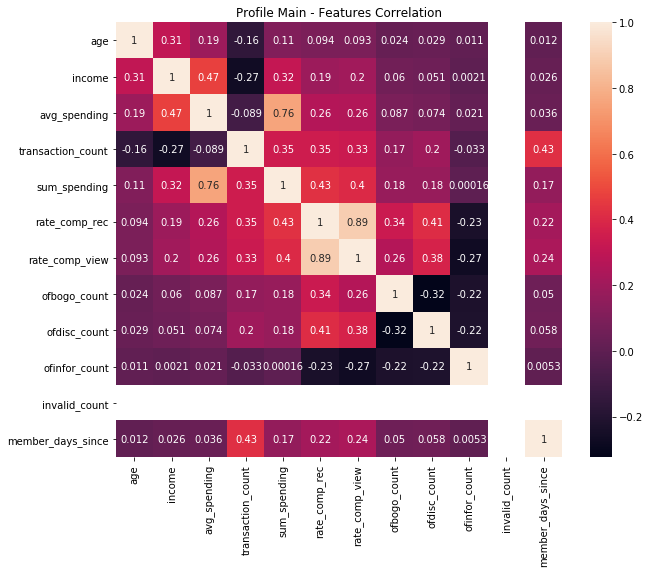

In [104]:
#%% ！！！数据分析 ，热图 EDA 指定列，分别针对<100 >100

cols = ['age', 'income', 'avg_spending', 'transaction_count', 'sum_spending',
       'rate_comp_rec', 'rate_comp_view', 'ofbogo_count', 'ofdisc_count',
       'ofinfor_count', 'invalid_count', 'member_days_since']

f,ax = plt.subplots(figsize=(10,8))
sns.heatmap(profile_new[cols].corr(), ax=ax, annot=True)
ax.set_title("Profile Main - Features Correlation")


- 'rate_comp_view'和'rate_comp_rec'有很强的关联性
    
    
- 'rate_comp_view' and'rate_comp_rec' have a strong correlation

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


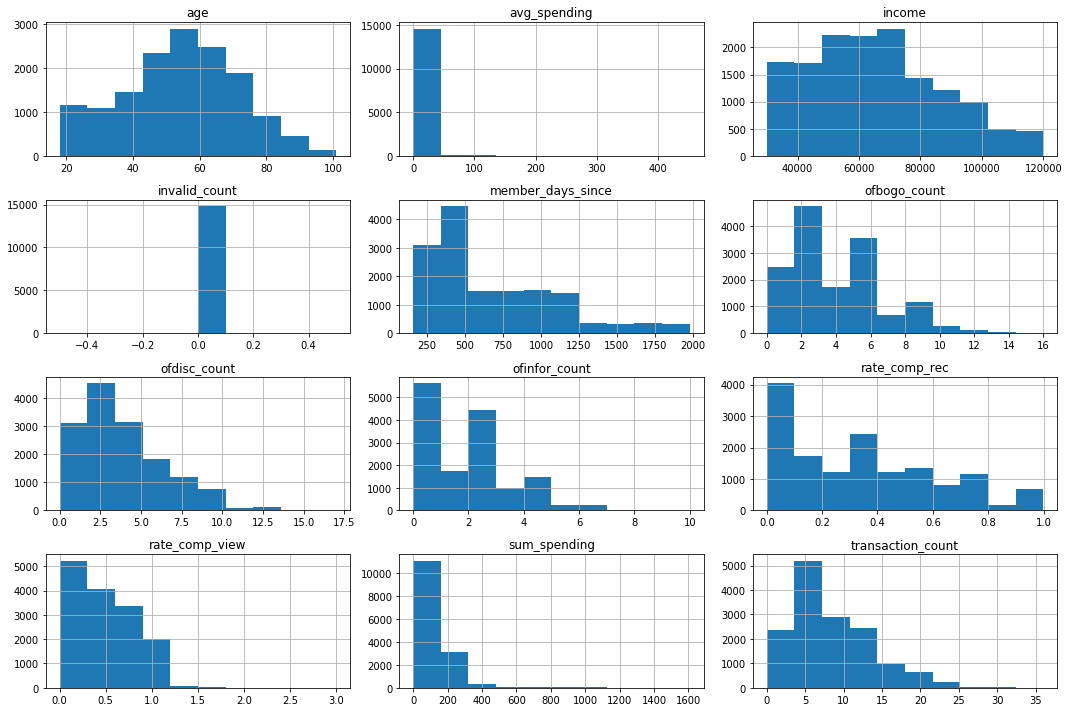

In [105]:
#%%数据分析 hist图

f, ax = plt.subplots(figsize=(15,10))
profile_new[cols].hist(ax=ax);
plt.tight_layout()
